# Benchmark: Elastic Collision with Material Point Method

## Particle and Background Mesh Generation:

In [4]:
import numpy as np
from scipy.spatial import Delaunay
from matplotlib import path
import matplotlib.patches as patches
import matplotlib.pyplot as plt
n = 60
phi = (2*np.pi/n)*np.linspace(0,n,n+1)
pv1 = np.transpose(np.array([0.2*np.cos(phi), 0.2*np.sin(phi)]))

In [7]:
#####################################
# FEM Mesh by Delaunayn Triangulation
def pmesh(pv,hmax,nref):
    edge = len(pv)-1
    for i in range(0,edge):
        d = np.sqrt((pv[i+1,0]-pv[i,0])**2+(pv[i+1,1]-pv[i,1])**2)
        if hmax<d:
            n = np.ceil(d/hmax)
            nx = np.linspace(pv[i,0],pv[i+1,0],n+1)
            ny = np.linspace(pv[i,1],pv[i+1,1],n+1)
            for j in range(0,len(nx[1:-1])):
                pv = np.append(pv,[[nx[j+1],ny[j+1]]],axis=0)
    poly = pv[0:edge+1,:]
    pv = np.unique(pv,axis=0)
    a = hmax**2
    p = 0
    while (hmax**2/2.0)<a:
        tri = Delaunay(pv)
        conn = tri.simplices
        print(conn)
        A = np.zeros(len(conn))
        for i in range(0,len(conn)):
            A[i] = np.abs(0.5*(pv[conn[i,0],0]*(pv[conn[i,1],1]-pv[conn[i,2],1])+pv[conn[i,1],0]*(pv[conn[i,2],1]-pv[conn[i,0],1])+pv[conn[i,2],0]*(pv[conn[i,0],1]-pv[conn[i,1],1])))
        C = np.zeros((len(conn),2))
        D = np.zeros((len(conn),2))
        for j in range(0,len(conn)):
            K=np.array([[2*(pv[conn[j,0],0]-pv[conn[j,1],0]), 2*(pv[conn[j,0],1]-pv[conn[j,1],1])] , [2*(pv[conn[j,1],0]-pv[conn[j,2],0]), 2*(pv[conn[j,1],1]-pv[conn[j,2],1])]])
            F=np.array([((pv[conn[j,0],0])**2-(pv[conn[j,1],0])**2)+((pv[conn[j,0],1])**2-(pv[conn[j,1],1])**2) , ((pv[conn[j,1],0])**2-(pv[conn[j,2],0])**2)+((pv[conn[j,1],1])**2-(pv[conn[j,2],1])**2)])
            c = np.linalg.inv(K).dot(F)
            C[j,:] = [c[0], c[1]]
            D[j,:] = [np.mean([(pv[conn[j,0],0]),(pv[conn[j,1],0]),(pv[conn[j,2],0])]) , np.mean([(pv[conn[j,0],1]),(pv[conn[j,1],1]),(pv[conn[j,2],1])])]
        pp = path.Path(poly)
        in_check = pp.contains_points(D)
        delete = np.where(in_check == False)
        A = np.delete(A,delete)
        C = np.delete(C,delete,axis=0)
        conn = np.delete(conn,delete,axis=0)
        if max(A)<(hmax**2/2):
            break
        else:
            ind = np.argmax(A)
            pv = np.append(pv,[[C[ind,0],C[ind,1]]],axis=0)
            pv = np.unique(pv,axis=0)
        p = p+1
    
    return pv, conn
###################################

###################################
# Regular Mesh
def regular2Dmesh(L1,h1,L2,h2):
    el1 = int(np.ceil(L1/h1))
    el2 = int(np.ceil(L2/h2))
    print(el1,el2)
    h1 = L1/el1
    h2 = L2/el2
    size1 = np.linspace(0,L1,el1+1)
    size2 = np.linspace(0,L2,el2+1)
    nel = el1*el2
    X1,Y1 = np.meshgrid(size1,size2)
    nodes = np.zeros((len(size1)*len(size2),2))
    k = 0
    for i in range(0,len(size2)):
        for j in range(0,len(size1)):
            nodes[k,0] = X1[i,j]
            nodes[k,1] = Y1[i,j]
            k = k+1
    conn = np.zeros(((nel,4)),dtype=int)
    for k in range(0,el2):
        for i in range(0,el1):
            conn[i+el1*k,:] = [i+(el1+1)*k, i+(el1+1)*k+1, i+(el1+1)*(k+1)+1, i+(el1+1)*(k+1)]
    return nodes,conn,el1,el2,h1,h2
##################################

In [9]:
p,t = pmesh(pv1,0.032,0)
set1 = (1/3.0)*np.transpose(np.array([p[t[:,0],0]+p[t[:,1],0]+p[t[:,2],0] , p[t[:,0],1]+p[t[:,1],1]+p[t[:,2],1]]))
set1 = set1 + 0.2*np.ones((len(t),2))
set2 = set1 + 0.6*
L1 = 1.0
L2 = 1.0
h1 = 0.05
h2 = 0.05
nodes, conn, el1, el2, h1, h2 = regular2Dmesh(L1,h1,L2,h2)

[[37  5  7]
 [23 37 21]
 [17 37 15]
 [37 40 38]
 [37 49 51]
 [37 27 29]
 [ 9 37  7]
 [37 13 15]
 [37 41 43]
 [ 1 37  0]
 [37 33 35]
 [53 37 51]
 [31 37 29]
 [37 32 30]
 [37  2  0]
 [45 37 43]
 [37 20 18]
 [16 37 18]
 [37 16 14]
 [20 37 22]
 [12 37 14]
 [37 12 10]
 [28 37 30]
 [24 37 26]
 [37 24 22]
 [37 28 26]
 [37 10  8]
 [ 2 37  4]
 [37  6  4]
 [ 6 37  8]
 [37 58 56]
 [50 37 52]
 [37 50 48]
 [37 54 52]
 [54 37 56]
 [58 37 59]
 [37 19 21]
 [36 37 38]
 [46 37 48]
 [42 37 44]
 [37 46 44]
 [32 37 34]
 [37 57 59]
 [37 36 34]
 [40 37 42]
 [37  1  3]
 [ 5 37  3]
 [13 37 11]
 [37  9 11]
 [27 37 25]
 [37 23 25]
 [19 37 17]
 [57 37 55]
 [37 53 55]
 [37 45 47]
 [49 37 47]
 [37 31 33]
 [41 37 39]]
[[18 16 29]
 [59 29 60]
 [ 1 29  0]
 [46 48 29]
 [29  2  0]
 [ 4  2 29]
 [ 8  6 29]
 [ 6  4 29]
 [16 14 29]
 [14 12 29]
 [10  8 29]
 [12 10 29]
 [28 29 31]
 [28 26 29]
 [24 22 29]
 [26 24 29]
 [22 20 29]
 [20 18 29]
 [57 55 29]
 [59 57 29]
 [49 47 29]
 [51 49 29]
 [55 53 29]
 [53 51 29]
 [29 33 31]
 [3

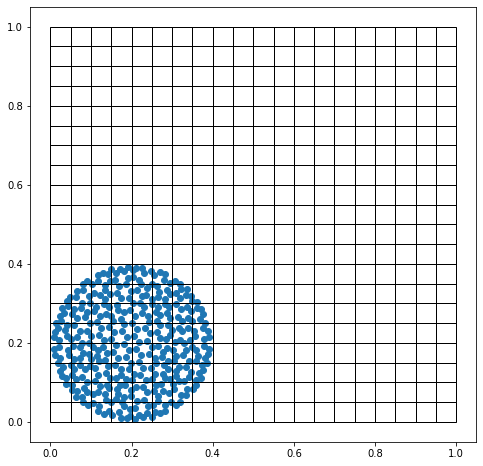

In [30]:
plt.figure(figsize=(8,8))
#ax = fig.gca()
#ax.axis('equal')
#for i in range(0,len(conn)):
#    ax.add_patch(patches.Polygon([[nodes[conn[i,0],0],nodes[conn[i,0],1]],[nodes[conn[i,1],0],nodes[conn[i,1],1]],[nodes[conn[i,2],0],nodes[conn[i,2],1]],[nodes[conn[i,3],0],nodes[conn[i,3],1]]],facecolor=[.8,1,.8],edgecolor='k'))
#plt.scatter(set1[:,0],set1[:,1])
for i in range(0,len(conn)):
    plt.gca().add_patch(patches.Polygon([[nodes[conn[i,0],0],nodes[conn[i,0],1]],[nodes[conn[i,1],0],nodes[conn[i,1],1]],[nodes[conn[i,2],0],nodes[conn[i,2],1]],[nodes[conn[i,3],0],nodes[conn[i,3],1]]],facecolor='w',edgecolor='k',fill=False))
plt.scatter(set1[:,0],set1[:,1])
